## Description
This notebook focuses exclusively on manually labelled datasets for testing purposes. Using a BERT model, word embeddings are generated for each individual word in the dataset and compared to the word embeddings of the keyword pool.

Only the best score of the top_n words from an entry are taken to calculate the similarity score for a dataset. An iterative process then defines the best threshold based on the f1_score (alternative on the precision, recall or accuracy).

Different scatter plots visualize the resulting similarities, providing insight into why it can be challenging to determine whether a dataset relates to mobility data or not.

The code was developed with support from ChatGPT-4.

In [19]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Define parameters
model_name = 'google-bert/bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
mobility_keywords_file = 'data/mobility_keywords_pool.txt'
inputdata_file = 'data/03_labelled_data.csv'
outputdata_file = 'data/04_predicted_data.csv'

top_n = 2

In [20]:
# Function to convert string into list
def str_to_list(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

In [21]:
# read csv inputdata_file
df = pd.read_csv(inputdata_file, dtype={'mobilitydata_labelled': 'string'},converters={'combined_DE_keywords': str_to_list}, low_memory=False)

# Drop rows where 'mobilitydata_labelled' is empty (NaN)
df = df.dropna(subset=['mobilitydata_labelled'])

# Convert 'mobilitydata_labelled' to boolean type
df['mobilitydata_labelled'] = df['mobilitydata_labelled'].map({'True': True, 'False': False})

# Print the number of rows remaining after filtering
print(f"Number of labelled rows after filtering: {len(df)}")

Number of labelled rows after filtering: 106


In [22]:
# Inferenz auf GPU, falls verfügbar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Funktion zum Erzeugen von Satz-Embeddings (Mean Pooling)
def get_bert_embeddings(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # mean pooling über Token-Dimension
    return embeddings.cpu().numpy()

# Keywords laden
with open(mobility_keywords_file, 'r', encoding='utf-8') as file:
    mobility_keywords = [line.strip() for line in file if line.strip()]

# Vektor-Repräsentationen erzeugen
keyword_embeddings = get_bert_embeddings(mobility_keywords)

In [23]:
def process_entry(word_list):
    # Falls das Feld leer oder keine Liste ist, gib leere Ergebnisse zurück
    if not isinstance(word_list, list):
        return {'words': [], 'similarity_matrix': []}
    
    # Embeddings für jedes Wort in der Liste berechnen
    embeddings = get_bert_embeddings(word_list)  # Liste von Wörtern rein
    similarity_matrix = cosine_similarity(embeddings, keyword_embeddings).tolist()
    
    return {
        'words': word_list,
        'similarity_matrix': similarity_matrix
    }

# Anwenden auf DataFrame-Spalte
df[['words', 'similarity_matrix']] = df['combined_DE_keywords'].apply(
    lambda x: pd.Series(process_entry(x))
)


In [24]:
# Function to calculate the similarity of the top_n words
def get_avg_similarity(sim_matrix, top_n):
    # Return NaN if the matrix is empty or None
    if not sim_matrix or len(sim_matrix) == 0:
        return float('nan')
    
    # For each row (i.e., each word), get the highest similarity score
    max_per_word = [max(row) for row in sim_matrix if row]  # Handles empty rows safely
    
    # Take the top N scores, or as many as available
    top_scores = sorted(max_per_word, reverse=True)[:top_n]
    
    # Calculate the average of the top N scores
    if top_scores:
        return sum(top_scores) / len(top_scores)
    else:
        return float('nan')

In [25]:
# Function to apply the similarity checking function to the DataFrame
def apply_similarity_check(row, threshold):
    similarity_score = row['avg_similarity']
    if pd.isna(similarity_score):
        return pd.Series([False, similarity_score])
    label = similarity_score >= threshold
    return pd.Series([label, similarity_score])

In [26]:
# Function to iterate and define the best threshold
def evaluate_threshold(df, threshold, top_n):
    # Recalculate avg_similarity
    df['avg_similarity'] = df['similarity_matrix'].apply(lambda sim_matrix: get_avg_similarity(sim_matrix, top_n=top_n))

    # Recalculate prediction based on threshold
    df['mobilitydata_predicted'] = df['avg_similarity'] >= threshold

    # Define categories based on confusion matrix results
    df['confusion_matrix_category'] = 'Unknown'
    df.loc[(df['mobilitydata_labelled'] == True) & (df['mobilitydata_predicted'] == True), 'confusion_matrix_category'] = 'True Positive'
    df.loc[(df['mobilitydata_labelled'] == False) & (df['mobilitydata_predicted'] == False), 'confusion_matrix_category'] = 'True Negative'
    df.loc[(df['mobilitydata_labelled'] == False) & (df['mobilitydata_predicted'] == True), 'confusion_matrix_category'] = 'False Positive'
    df.loc[(df['mobilitydata_labelled'] == True) & (df['mobilitydata_predicted'] == False), 'confusion_matrix_category'] = 'False Negative'

    # Count categories
    counts = df['confusion_matrix_category'].value_counts()
    TP = counts.get('True Positive', 0)
    TN = counts.get('True Negative', 0)
    FP = counts.get('False Positive', 0)
    FN = counts.get('False Negative', 0)

    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score  = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
    'threshold': threshold,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'accuracy': accuracy,
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN
}

In [27]:
thresholds = np.arange(0.0, 1.01, 0.01)
results = [evaluate_threshold(df.copy(), t, top_n=5) for t in thresholds]

# In DataFrame umwandeln
results_df = pd.DataFrame(results)

# Besten Threshold nach F1-Score finden
best_row = results_df.loc[results_df['f1_score'].idxmax()]
threshold = best_row['threshold']

# Apply the best threshold to the original DataFrame
evaluate_threshold(df, threshold, top_n=5)

# Update category_counts based on the original DataFrame
category_counts = df['confusion_matrix_category'].value_counts()

print(f"Best threshold based on F1-score: {threshold:.2f}")
print(best_row)

Best threshold based on F1-score: 0.87
threshold     0.870000
precision     0.714286
recall        0.294118
f1_score      0.416667
accuracy      0.867925
TP            5.000000
TN           87.000000
FP            2.000000
FN           12.000000
Name: 87, dtype: float64


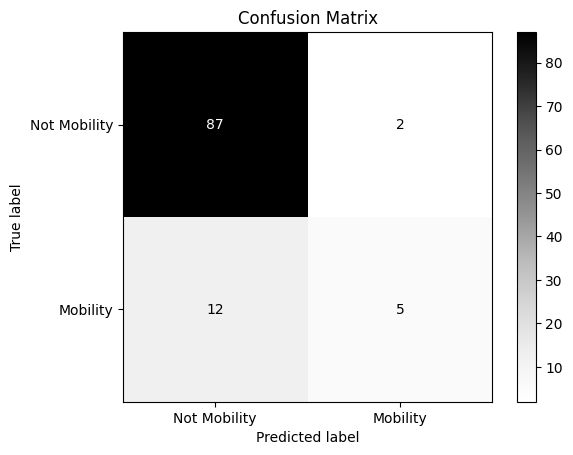

In [28]:
# Generate the confusion matrix using boolean columns
cm = confusion_matrix(df['mobilitydata_labelled'], df['mobilitydata_predicted'])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Mobility", "Mobility"])
disp.plot(cmap=plt.cm.Greys)
plt.title('Confusion Matrix')
plt.show()

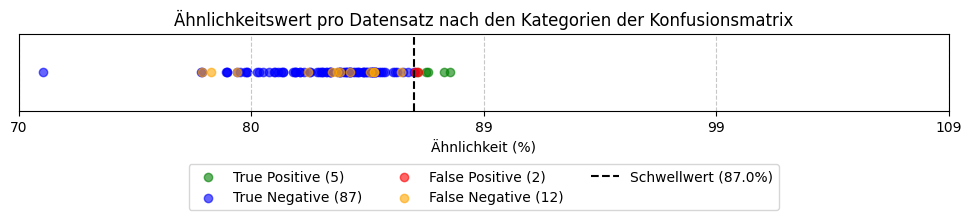

In [29]:
# Define colors for each category
colors = {
    'True Positive': 'green',
    'True Negative': 'blue',
    'False Positive': 'red',
    'False Negative': 'orange'
}

# Create a scatter plot
plt.figure(figsize=(12, 1))
for category, color in colors.items():
    subset = df[df['confusion_matrix_category'] == category]
    count = category_counts.get(category, 0)
    plt.scatter(subset['avg_similarity'], [0] * len(subset), color=color, label=f"{category} ({count})", alpha=0.6)

# Plot the threshold line
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Schwellwert ({100*threshold}%)')

# Create custom tick labels as percentages
tick_vals = np.arange(0.7, 1.1, 0.1)
tick_labels = [f"{int(x * 100)}" for x in tick_vals]

# Plot formatting
plt.title('Ähnlichkeitswert pro Datensatz nach den Kategorien der Konfusionsmatrix')
plt.xlabel('Ähnlichkeit (%)')
plt.xlim(0.7, 1)
plt.yticks([])
plt.xticks(tick_vals, tick_labels)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=3)
plt.show()


In [30]:
def plot_similarity(df, mobility_keywords, case='worst_fn'):
    """
    Plots the similarity distribution for a specific case:
    case: 'worst_fn' (False Negative with lowest similarity)
          'best_tp'  (True Positive with highest similarity)
    """
    assert case in ['worst_fn', 'best_tp'], "case must be 'worst_fn' or 'best_tp'"

    # Filter by desired category
    if case == 'worst_fn':
        subset = df[df['confusion_matrix_category'] == 'False Negative']
        index = subset['avg_similarity'].idxmin()
        title_case = 'worst False Negative'
    elif case == 'best_tp':
        subset = df[df['confusion_matrix_category'] == 'True Positive']
        index = subset['avg_similarity'].idxmax()
        title_case = 'best True Positive'

    # Get row data
    row = df.loc[index]
    words = row['words']
    sim_matrix = row['similarity_matrix']

    if not words or not sim_matrix:
        print(f"No content for index {index}")
        return

    num_keywords = len(mobility_keywords)
    num_words = len(words)

    plt.figure(figsize=(max(10, num_keywords * 0.4), 6))

    # Define color map for keywords
    colors = plt.cm.get_cmap('tab20', num_keywords)
    sim_matrix_T = list(zip(*sim_matrix))  # Transpose: keywords x words

    # Scatterplot: for each keyword, plot similarity to all words
    for keyword_idx, keyword in enumerate(mobility_keywords):
        similarities = [score * 100 for score in sim_matrix_T[keyword_idx]]
        plt.scatter(range(num_words), similarities, color=colors(keyword_idx), label=keyword)

    # Plot the threshold line
    plt.axhline(y=100*threshold, color='black', linestyle='--', label=f'Schwellwert ({100*threshold:.1f}%)')

    # Plot top-n average similarity (stored in DataFrame)
    plt.axhline(y=100*row['avg_similarity'], color='gray', linestyle=':', linewidth=1, label=f"Top-{top_n} Durchschnitt ({100*row['avg_similarity']:.1f}%)")

    # Axes & layout
    plt.xticks(ticks=range(num_words), labels=words, rotation=45, ha='right')
    plt.ylabel("Ähnlichkeit (%)")
    plt.xlabel("Vorprozessierte Keywords")
    plt.title(f"Mobility-Keyword-Ähnlichkeit pro Wort des \"{title_case}\", Score {row['avg_similarity']:.3f})")
    plt.ylim(0, 100)
    plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0), fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()


C:\Users\haabs\AppData\Local\Temp\ipykernel_90384\1692945724.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_keywords)


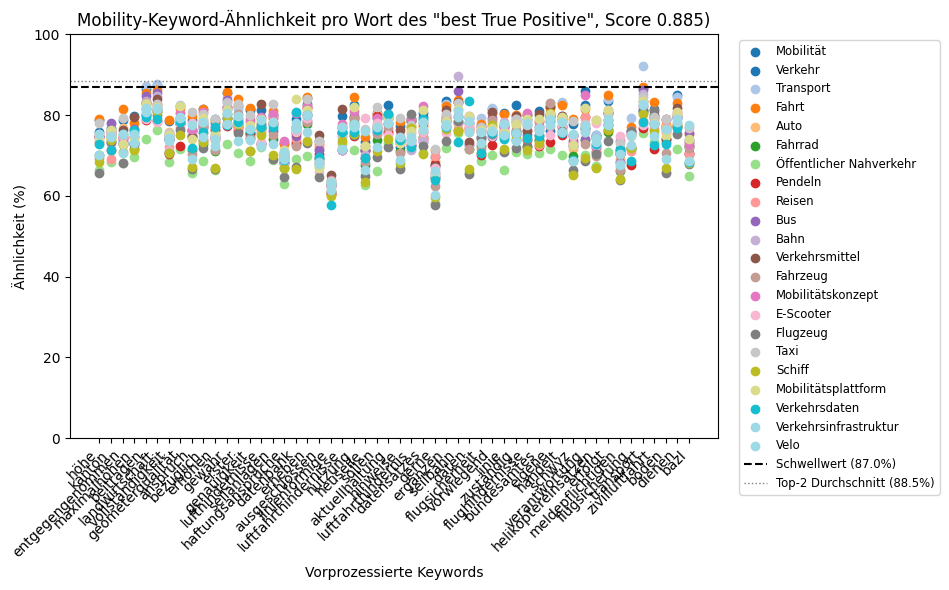

C:\Users\haabs\AppData\Local\Temp\ipykernel_90384\1692945724.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_keywords)


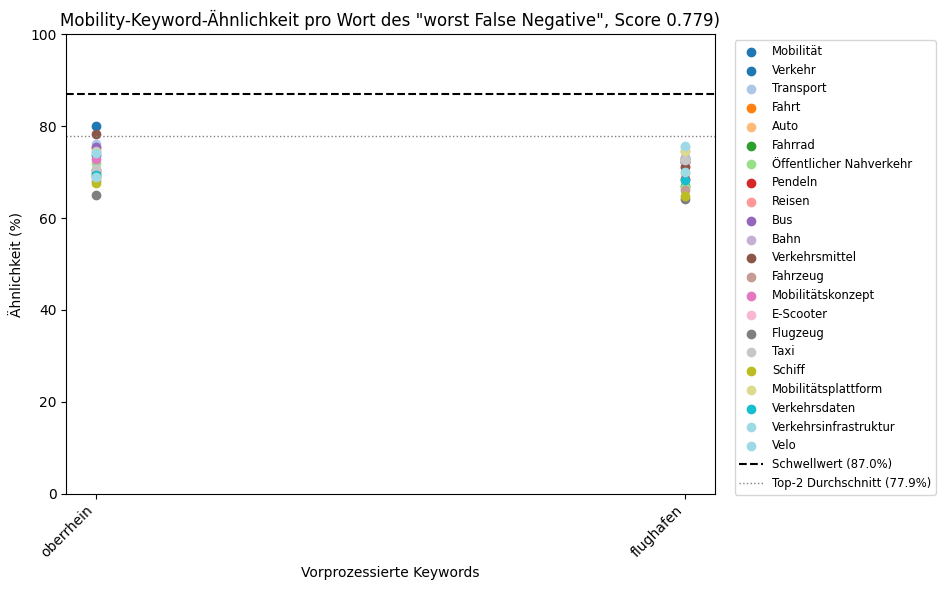

In [31]:
# Plot the best True Positive
plot_similarity(df, mobility_keywords, case='best_tp')

# Plot the worst False Negative
plot_similarity(df, mobility_keywords, case='worst_fn')


In [32]:
# Drop unnecessary columns before saving
columns_to_drop = ['similarity_matrix', 'words']  # columns to remove
df = df.drop(columns=columns_to_drop, errors='ignore')

# Write the DataFrame to a new CSV file
df.to_csv(outputdata_file, index=False)

print(f'The file has been successfully saved as {outputdata_file}.')

The file has been successfully saved as data/04_predicted_data.csv.
